<h1><b><u>XGBOOST and LSTM Time Series</u></b></h1>
In this project, we aimed to compare the performance of XGBoost and LSTM models for time series forecasting. We selected a suitable time series dataset that exhibited diverse characteristics such as trends, seasonality, irregular patterns, or long-term dependencies. The dataset was preprocessed to handle missing values, normalize or scale the data, and prepare it for input into the models.
<br>
We implemented the XGBoost algorithm, configuring the model with appropriate hyperparameters such as tree depth, learning rate, and regularization. The XGBoost model was trained on the training dataset, and its performance was evaluated using metrics such as mean absolute error (MAE) or root mean squared error (RMSE).
<br>
We also developed an LSTM model using a deep learning framework like Keras or TensorFlow. The LSTM architecture was designed with the desired number of layers and hidden units. The data was prepared in the appropriate input format, and the LSTM model was trained on the training dataset. The model's performance was evaluated using relevant evaluation metrics.
<br>
We compared the forecasting accuracy of the XGBoost and LSTM models, considering their strengths and weaknesses in handling different time series patterns. We used quantitative metrics such as MAE, RMSE, or mean absolute percentage error (MAPE) to assess their performance. We visualized the forecasted results and analyzed feature importance measures for the XGBoost model to gain insights into the interpretability of the results.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
sns.set(style = 'darkgrid', palette = 'deep', color_codes = True)
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/OrderLeads.csv')
data.head()

,Order Id,Company Id,Company Name,Date,Order Value,Converted
0,80EYLOKP9E762WKG,LJKS5NK6788CYMUU,Chimera-Chasing Casbah,18-02-2017,4875,1
1,TLEXR1HZWTUTBHPB,LJKS5NK6788CYMUU,Chimera-Chasing Casbah,30-07-2015,8425,0
2,839FKFW2LLX4LMBB,LJKS5NK6788CYMUU,Chimera-Chasing Casbah,27-05-2016,4837,0
3,97OX39BGVMHODLJM,LJKS5NK6788CYMUU,Chimera-Chasing Casbah,27-09-2018,343,0
4,5T4LGH4XGBWOD49Z,LJKS5NK6788CYMUU,Chimera-Chasing Casbah,14-01-2016,983,0


In [ ]:
# --------------------- Preprocess the data -----------------------
def preprocess(data, response_variable, time_variable):
    pre_data = data[[time_variable, response_variable]]
    pre_data[time_variable] = pd.to_datetime(pre_data[time_variable])
    pre_data = pre_data.sort_values(by = time_variable, ascending = True)
    pre_data.set_index(time_variable, inplace = True)
    pre_data = pre_data.resample('D').mean().round(0)
    return pre_data

df = preprocess(data, 'Order Value', 'Date')
df.rename(columns = {'Order Value':'orders'}, inplace = True)
df

,orders
Date,
2014-01-01,4598.0
2014-01-02,4678.0
2014-01-03,4724.0
2014-01-04,4609.0
2014-01-05,4937.0
...,...
2018-12-27,5011.0
2018-12-28,5451.0
2018-12-29,4957.0


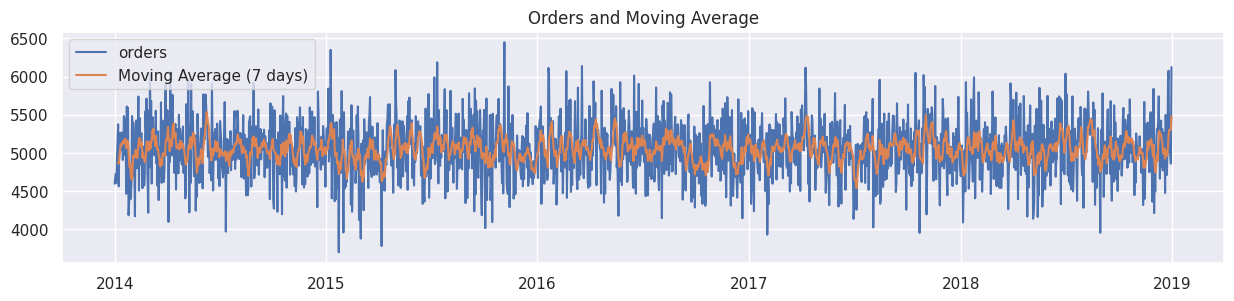

In [ ]:
# ------ Plot showing the response variable and its moving average ----------------
def plotter(data, response, titles, windows):
    window_size = windows  # Define the window size for the moving average
    data['Moving Average'] = data[response].rolling(window=window_size).mean()

    # Plot the orders data and the moving average
    plt.figure(figsize=(15, 3))  # Adjust the figure size as desired
    plt.plot(data.index, data[response], label= response)
    plt.plot(data.index, data['Moving Average'], label=f'Moving Average ({window_size} days)')
    plt.title(titles)
    plt.legend()

plotter(df, 'orders', 'Orders and Moving Average', 7)

<hr>
<h3><b>Outlier Removal</b></h3>

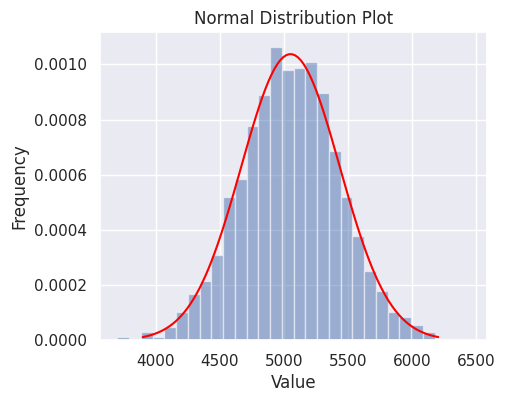

In [ ]:
# --------------  Plot Normal Distribution Curve  -----------
from scipy.stats import norm
def normal_curve_plot(data):
    mean_data, std_data = np.mean(data), np.std(data)
    # Generate a range of values along the x-axis for the normal distribution plotting
    x = np.linspace(start = mean_data - 3 * std_data, stop = mean_data + 3 * std_data, num = 100)
    # Calculate the probability density function values using scipy.stats.norm
    y = norm.pdf(x, mean_data, std_data)
    # Plot the histogram of your data
    plt.figure(figsize = (5,4))
    plt.hist(data, bins=30, density=True, alpha=0.5, label='Data')
    # Plot the normal distribution curve
    plt.plot(x, y, color='red', label='Normal Distribution')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Normal Distribution Plot')
    plt.show()

normal_curve_plot(df.orders.values)

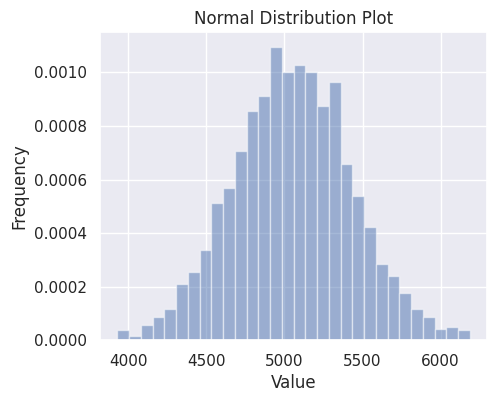

In [ ]:
# ------------------ Remove Outliers using the ZScore --------------------
def remove_outliers_zscore(data, threshold=3):
    z_scores = (data - np.mean(data)) / np.std(data)
    filtered_data = data[abs(z_scores) < threshold]
    return filtered_data

new_data = df.copy()
new_data['clean_orders'] = remove_outliers_zscore(new_data.orders, threshold = 3)
normal_curve_plot(new_data.clean_orders.values)

In [ ]:
new_data = new_data[['clean_orders']].dropna()
new_data

,clean_orders
Date,
2014-01-01,4598.0
2014-01-02,4678.0
2014-01-03,4724.0
2014-01-04,4609.0
2014-01-05,4937.0
...,...
2018-12-27,5011.0
2018-12-28,5451.0
2018-12-29,4957.0


In [ ]:
# df[['orders']].query("orders > 5900").plot(style = '.', color='red', figsize = (9, 2), title = 'Data Points Above 5350')
# df[['orders']].query("orders < 4000").plot(style = '.', color='blue', figsize = (9, 2), title = 'Data Points below 4800')

<hr>
<h3><b>Feature Creation</b></h3>

In [ ]:
# Create features for the forecast horizon
def add_extra_features(data):
    data['month'] = data.index.month
    data['year'] = data.index.year
    data['weekOfYear'] = data.index.isocalendar().week.astype(int)
    data['dayOfWeek'] = data.index.dayofweek
    data['dayOfMonth'] = data.index.day
    data['dayOfYear'] = data.index.dayofyear
    data['quarter'] = data.index.quarter

    return data

new_data = add_extra_features(data = new_data[['clean_orders']])
new_data

,clean_orders,month,year,weekOfYear,dayOfWeek,dayOfMonth,dayOfYear,quarter
Date,,,,,,,,
2014-01-01,4598.0,1,2014,1,2,1,1,1
2014-01-02,4678.0,1,2014,1,3,2,2,1
2014-01-03,4724.0,1,2014,1,4,3,3,1
2014-01-04,4609.0,1,2014,1,5,4,4,1
2014-01-05,4937.0,1,2014,1,6,5,5,1
...,...,...,...,...,...,...,...,...
2018-12-27,5011.0,12,2018,52,3,27,361,4
2018-12-28,5451.0,12,2018,52,4,28,362,4
2018-12-29,4957.0,12,2018,52,5,29,363,4


Text(0.5, 1.0, 'Sales By Week Of The Year')

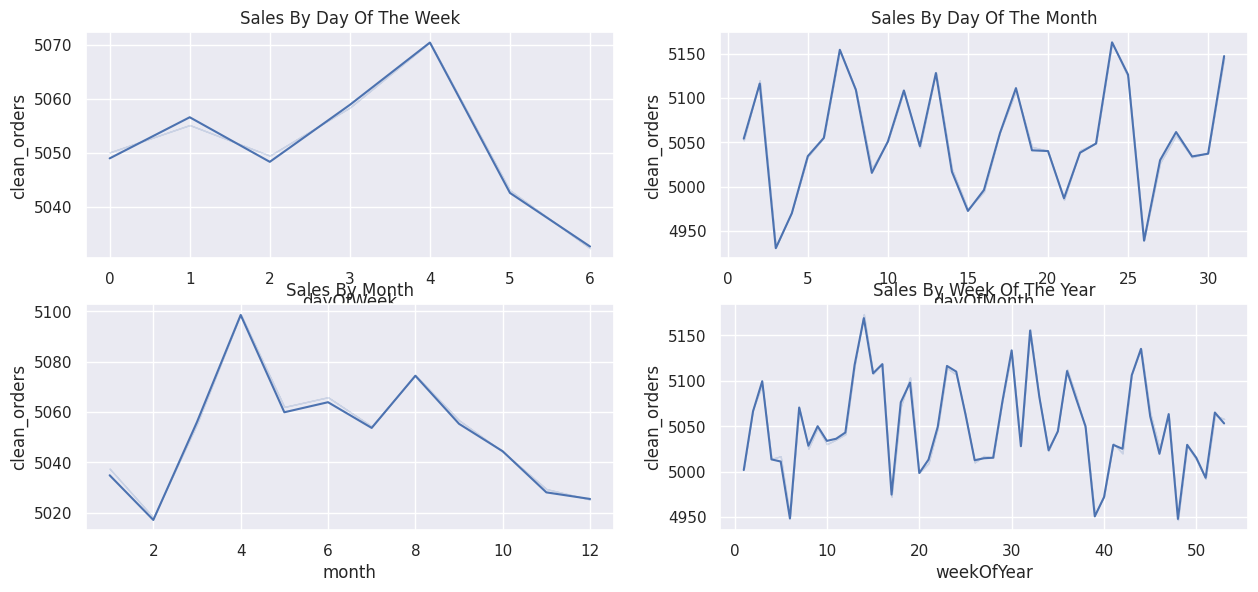

In [ ]:
# Show the weekly movt of sales
plt.figure(figsize=(15, 10))
plt.subplot(3,2,1)
sns.lineplot(x = new_data.dayOfWeek, y = new_data.clean_orders, ci = 0, estimator= 'mean')
plt.title('Sales By Day Of The Week')
plt.subplot(3,2,2)
sns.lineplot(x = new_data.dayOfMonth, y = new_data.clean_orders, ci = 0, estimator= 'mean')
plt.title('Sales By Day Of The Month')
plt.subplot(3,2,3)
sns.lineplot(x = new_data.month, y = new_data.clean_orders, ci = 0, estimator= 'mean')
plt.title('Sales By Month')
plt.subplot(3,2,4)
sns.lineplot(x = new_data.weekOfYear, y = new_data.clean_orders, ci = 0, estimator= 'mean')
plt.title('Sales By Week Of The Year')


From the graph above, we can deduce that sales starts to increase from Friday through to Saturday, then drops back to average Saturday through to Sunday.

<hr>
<h3><b>Train and Test Split</b></h3>


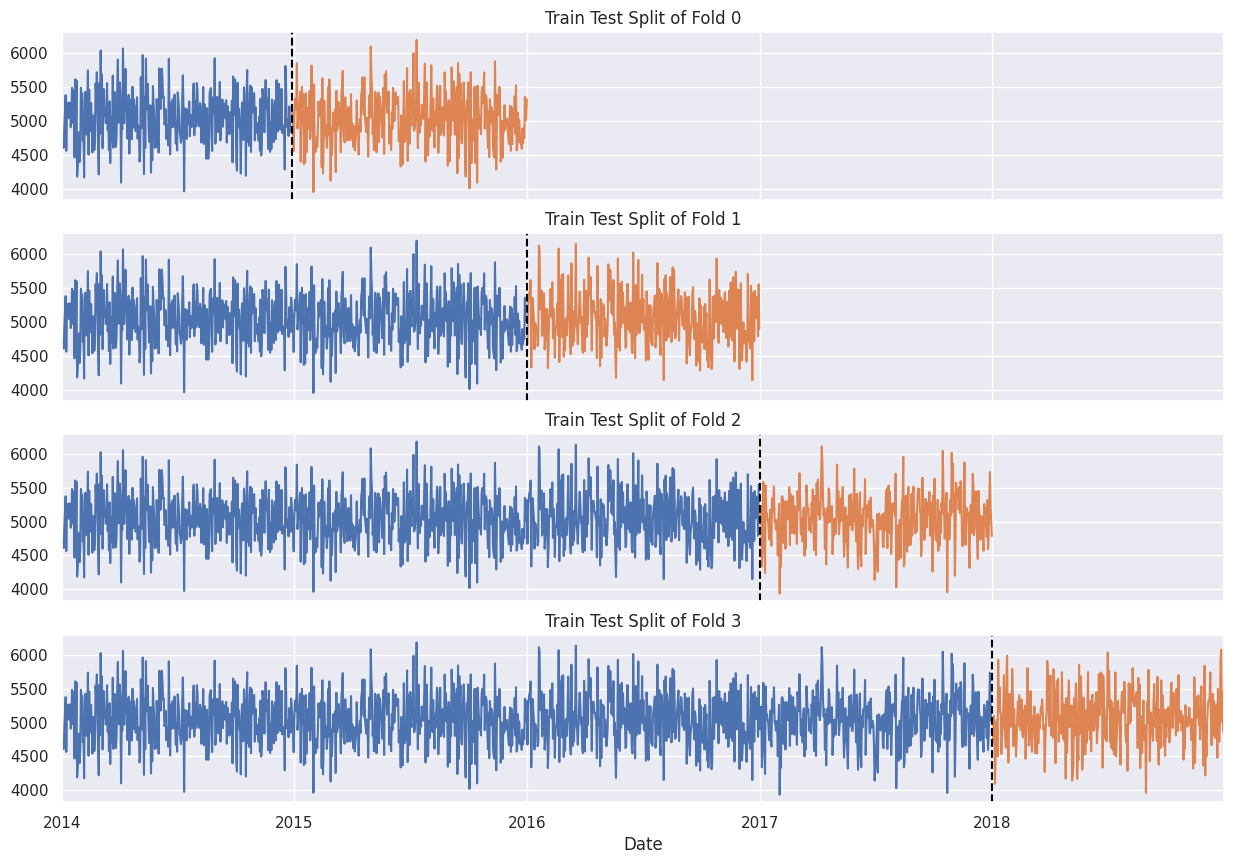

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
timeSplit = TimeSeriesSplit(n_splits = 4, test_size = 365, gap = 1)

fold = 0

fig, axs = plt.subplots(4,1, figsize = (15,10), sharex = True)

for index_of_train, index_of_val in timeSplit.split(new_data):
    train = new_data.iloc[index_of_train]
    test = new_data.iloc[index_of_val]
    train['clean_orders'].plot(ax = axs[fold],
                                  label = 'Training Set',
                                  title = f"Train Test Split of Fold {fold}")
    test['clean_orders'].plot(ax = axs[fold],
                                label = 'Test Set')
    axs[fold].axvline(test.index.min(), color = 'black', ls = '--')
    fold += 1
plt.show()

<hr>
<h2><b>Lag Features</b></h2>
In a time series, each observation is associated with a specific time point or period in the past. Hence, Lag features involve taking past observations from the same time series and including them as predictors in the model. These lagged values capture the relationship between the variable's past behavior and its current or future behavior.

In [ ]:
# Add lag features using the pandas shift function
# We are using 364 because it is divisable by 7, and so fits perfectly by week
def add_lag(data):
    data['lag365'] = data['clean_orders'].shift(364)
    data['lag729'] = data['clean_orders'].shift(728)
    data['lag1095'] = data['clean_orders'].shift(1092)
    return data

add_lag(new_data)  # ........................................... Call the function on the dataframe

,clean_orders,month,year,weekOfYear,dayOfWeek,dayOfMonth,dayOfYear,quarter,lag365,lag729,lag1095
Date,,,,,,,,,,,
2014-01-01,4598.0,1,2014,1,2,1,1,1,NaN,NaN,NaN
2014-01-02,4678.0,1,2014,1,3,2,2,1,NaN,NaN,NaN
2014-01-03,4724.0,1,2014,1,4,3,3,1,NaN,NaN,NaN
2014-01-04,4609.0,1,2014,1,5,4,4,1,NaN,NaN,NaN
2014-01-05,4937.0,1,2014,1,6,5,5,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,5011.0,12,2018,52,3,27,361,4,5736.0,4789.0,5013.0
2018-12-28,5451.0,12,2018,52,4,28,362,4,5205.0,5549.0,5319.0
2018-12-29,4957.0,12,2018,52,5,29,363,4,5022.0,4898.0,4673.0


In [ ]:
# Display the lags for each lag feature
display(new_data.iloc[364:].head())
display(new_data.iloc[728:].head())
display(new_data.iloc[1095:].head())

,clean_orders,month,year,weekOfYear,dayOfWeek,dayOfMonth,dayOfYear,quarter,lag365,lag729,lag1095
Date,,,,,,,,,,,
2014-12-31,4559.0,12,2014,1,2,31,365,4,4598.0,NaN,NaN
2015-01-01,5062.0,1,2015,1,3,1,1,1,4678.0,NaN,NaN
2015-01-02,5319.0,1,2015,1,4,2,2,1,4724.0,NaN,NaN
2015-01-03,5326.0,1,2015,1,5,3,3,1,4609.0,NaN,NaN
2015-01-04,5167.0,1,2015,1,6,4,4,1,4937.0,NaN,NaN


,clean_orders,month,year,weekOfYear,dayOfWeek,dayOfMonth,dayOfYear,quarter,lag365,lag729,lag1095
Date,,,,,,,,,,,
2016-01-04,5342.0,1,2016,1,0,4,4,1,4559.0,4598.0,NaN
2016-01-05,5432.0,1,2016,1,1,5,5,1,5062.0,4678.0,NaN
2016-01-06,5444.0,1,2016,1,2,6,6,1,5319.0,4724.0,NaN
2016-01-07,5609.0,1,2016,1,3,7,7,1,5326.0,4609.0,NaN
2016-01-08,4335.0,1,2016,1,4,8,8,1,5167.0,4937.0,NaN


,clean_orders,month,year,weekOfYear,dayOfWeek,dayOfMonth,dayOfYear,quarter,lag365,lag729,lag1095
Date,,,,,,,,,,,
2017-01-05,4613.0,1,2017,1,3,5,5,1,5609.0,5326.0,4609.0
2017-01-06,5588.0,1,2017,1,4,6,6,1,4335.0,5167.0,4937.0
2017-01-07,5565.0,1,2017,1,5,7,7,1,5150.0,5844.0,5149.0
2017-01-08,4680.0,1,2017,1,6,8,8,1,5350.0,4890.0,5376.0
2017-01-09,4238.0,1,2017,2,0,9,9,1,5193.0,5023.0,4564.0


<hr>
<h3><b>XGBoost Modelling</b></h3>


In [ ]:
# We will create program that splits our data into varyng train and validation sets, then models each of these splits

timeSplit = TimeSeriesSplit(n_splits = 4, test_size = 365, gap = 1) # .......... Instantiate the splits

fold = 0
predictions = []
scores = []

for index_of_train, index_of_val in timeSplit.split(new_data):
# ------------ Iterate through the data by splits' index -----------------------
    train = new_data.iloc[index_of_train]
    test = new_data.iloc[index_of_val]

# ----------- Create train and test split from the CV split above for Modelling
    xtrain = train.drop('clean_orders', axis = 1)
    ytrain = train.clean_orders
    xtest = test.drop('clean_orders', axis = 1)
    ytest = test.clean_orders

# ----------- instantiate the XGBRegressor Model ------------------------------
    model = xgb.XGBRegressor(n_estimators = 1000, base_score = 0.5,
                             early_stopping_rounds = 50,
                             objective = 'reg:squarederror')
    model.fit(xtrain, ytrain,
          eval_set = [(xtrain, ytrain), (xtest, ytest)], verbose = 100)

    pred = model.predict(xtest)
    predictions.append(pred)
    scores.append(np.sqrt(mean_squared_error(ytest, pred)))

[0]	validation_0-rmse:3559.00282	validation_1-rmse:3540.94489
[61]	validation_0-rmse:80.93781	validation_1-rmse:457.69501
[0]	validation_0-rmse:3550.69311	validation_1-rmse:3573.59326
[65]	validation_0-rmse:136.70736	validation_1-rmse:429.97739
[0]	validation_0-rmse:3555.74810	validation_1-rmse:3555.99599
[62]	validation_0-rmse:160.21238	validation_1-rmse:430.24525
[0]	validation_0-rmse:3555.35265	validation_1-rmse:3565.52684
[64]	validation_0-rmse:184.55279	validation_1-rmse:441.14417


,importance
dayOfYear,0.166290
lag1095,0.149027
lag365,0.142758
lag729,0.135073
dayOfMonth,0.132687
weekOfYear,0.083642
dayOfWeek,0.076644
year,0.063002
month,0.050878
quarter,0.000000


<Axes: xlabel='importance'>

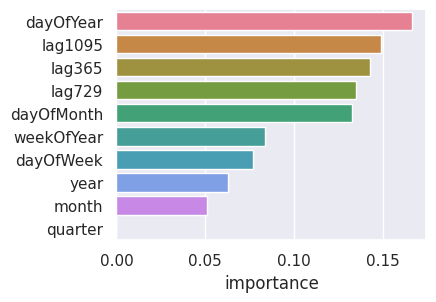

In [ ]:
# Plot the feature importance of the model
feat_importance = pd.DataFrame(model.feature_importances_, index = model.feature_names_in_, columns = ['importance'])\
                    .sort_values(by = 'importance', ascending = False)
display(feat_importance)
plt.figure(figsize = (4, 3))
sns.barplot(x = feat_importance['importance'], y = feat_importance.index, palette = 'husl', ci = 0)

<hr><h2><b>TEST THE MODEL</b></h2>
To test the model's prediction accuracy, we will need to add future dates to our original dataframe. Note that these future dates will extend beyond dates in the original dataframe.(This will be created using Pandas dateRange function), and we will be needing the lag features (because lag features where used in building the model).
Then these future dates will be predicted, thus revealing the accuracy of the timeseries model.

In [ ]:
# Get the start date for the future data
start_date = str(new_data.index.max())[:10]
start_date

'2018-12-31'

In [ ]:
future = pd.DataFrame(index = pd.date_range(start_date, '2019-03-30', freq = 'D')) # --- Create a dataframe with future date
future = add_extra_features(future) # -------------------------------------------------- Add the extra features function
future = pd.concat([new_data, future]) # ------------------------------------------------- Join the future data and old data along row axis
future = add_lag(future) # ------------------------------------------------------------- Add lag features for this new data for prediction
future

,clean_orders,month,year,weekOfYear,dayOfWeek,dayOfMonth,dayOfYear,quarter,lag365,lag729,lag1095
2014-01-01,4598.0,1,2014,1,2,1,1,1,NaN,NaN,NaN
2014-01-02,4678.0,1,2014,1,3,2,2,1,NaN,NaN,NaN
2014-01-03,4724.0,1,2014,1,4,3,3,1,NaN,NaN,NaN
2014-01-04,4609.0,1,2014,1,5,4,4,1,NaN,NaN,NaN
2014-01-05,4937.0,1,2014,1,6,5,5,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2019-03-26,NaN,3,2019,13,1,26,85,1,5912.0,5059.0,4967.0
2019-03-27,NaN,3,2019,13,2,27,86,1,5735.0,4504.0,5617.0
2019-03-28,NaN,3,2019,13,3,28,87,1,5281.0,5568.0,4571.0
2019-03-29,NaN,3,2019,13,4,29,88,1,4950.0,5251.0,5394.0


In [ ]:
# We will predict only the future date aspect of the dataframe that is not in the original dataframe.
# This is to ensure that none of the prediction data was previously used to train the model
# Hence we select the dates that are higher than the future dataframe's start date
future = future.loc[future.index > start_date]
future.head()

,clean_orders,month,year,weekOfYear,dayOfWeek,dayOfMonth,dayOfYear,quarter,lag365,lag729,lag1095
2019-01-01,NaN,1,2019,1,1,1,1,1,5098.0,4335.0,5444.0
2019-01-02,NaN,1,2019,1,2,2,2,1,4935.0,4613.0,5609.0
2019-01-03,NaN,1,2019,1,3,3,3,1,4091.0,5588.0,4335.0
2019-01-04,NaN,1,2019,1,4,4,4,1,4571.0,5565.0,5150.0
2019-01-05,NaN,1,2019,1,5,5,5,1,4990.0,4680.0,5350.0


In [ ]:
# Create a plot for plotting the actual and prediction
def actual_and_pred(actual, prediction):
    fig, axs = plt.subplots(figsize = (12, 4), sharex = True)
    actual.plot(ax = axs,
                      label = 'Original Data',
                      title = "TimeSeries Actual and Prediction Plot")
    prediction.plot(ax = axs,
                     label = 'Prediction')
    axs.axvline(prediction.index.min(), color = 'black', ls = '--')
    plt.legend()

In [ ]:
# Predict Existing Data.
# Pls Note that the model will drop in accuracy the further the forecast horizon.
test_table = new_data.iloc[1500:] # ------------- predict only 300+ rows

def predictor(data, response_variable):
    data['predict'] = model.predict(data.drop(response_variable, axis = 1))
    return data

predictor(test_table, 'clean_orders')

,clean_orders,month,year,weekOfYear,dayOfWeek,dayOfMonth,dayOfYear,quarter,lag365,lag729,lag1095,predict
Date,,,,,,,,,,,,
2018-02-14,4890.0,2,2018,7,2,14,45,1,5131.0,4921.0,4232.0,4873.116211
2018-02-15,4889.0,2,2018,7,3,15,46,1,5511.0,5266.0,4661.0,4884.550293
2018-02-16,5343.0,2,2018,7,4,16,47,1,4653.0,4804.0,5297.0,5172.154785
2018-02-17,4818.0,2,2018,7,5,17,48,1,5402.0,6072.0,4970.0,4937.061523
2018-02-18,4781.0,2,2018,7,6,18,49,1,4892.0,4413.0,4789.0,5048.236816
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,5011.0,12,2018,52,3,27,361,4,5736.0,4789.0,5013.0,5324.477051
2018-12-28,5451.0,12,2018,52,4,28,362,4,5205.0,5549.0,5319.0,4683.396973
2018-12-29,4957.0,12,2018,52,5,29,363,4,5022.0,4898.0,4673.0,5179.820801


In [ ]:
# Predict Future Data
predictor(future, 'clean_orders')

,clean_orders,month,year,weekOfYear,dayOfWeek,dayOfMonth,dayOfYear,quarter,lag365,lag729,lag1095,predict
2019-01-01,NaN,1,2019,1,1,1,1,1,5098.0,4335.0,5444.0,4678.220215
2019-01-02,NaN,1,2019,1,2,2,2,1,4935.0,4613.0,5609.0,5221.722656
2019-01-03,NaN,1,2019,1,3,3,3,1,4091.0,5588.0,4335.0,4856.085449
2019-01-04,NaN,1,2019,1,4,4,4,1,4571.0,5565.0,5150.0,4763.767090
2019-01-05,NaN,1,2019,1,5,5,5,1,4990.0,4680.0,5350.0,5041.554688
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-26,NaN,3,2019,13,1,26,85,1,5912.0,5059.0,4967.0,5104.364258
2019-03-27,NaN,3,2019,13,2,27,86,1,5735.0,4504.0,5617.0,5219.538086
2019-03-28,NaN,3,2019,13,3,28,87,1,5281.0,5568.0,4571.0,4602.476562
2019-03-29,NaN,3,2019,13,4,29,88,1,4950.0,5251.0,5394.0,4907.932129


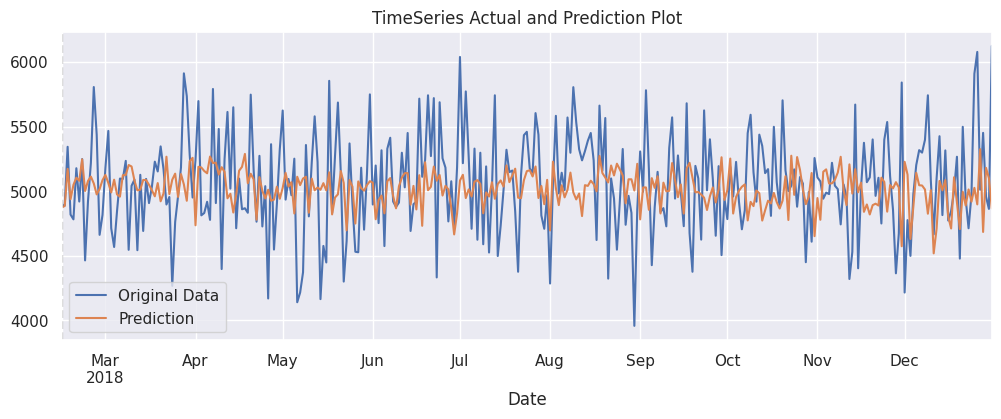

In [ ]:
# Plot the actual value and prediction value for present data
actual_and_pred(test_table.clean_orders, test_table.predict)

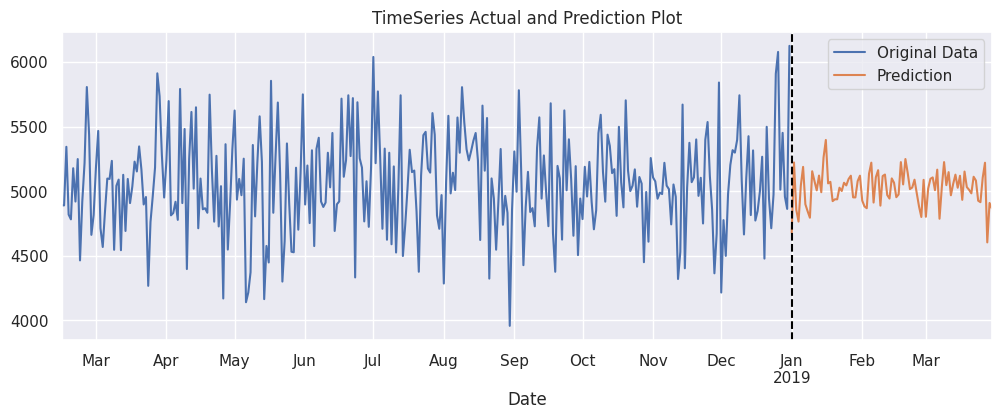

In [ ]:
# Plot predicted value for future data
actual_and_pred(new_data['clean_orders'].iloc[1500:], future.predict)

<hr><h2><b>SAVE MODEL</b></h2>

In [ ]:
# Save Model
model.save_model('timeseriesModel.json')

In [ ]:
# Load Model
new_model = xgb.XGBRegressor()
new_model.load_model('timeseriesModel.json')